## GLMAT: 2D kernel, noise stimulus, ML estimation

In [1]:
from __future__ import print_function, division
import os
import sys
import numpy as np
import scipy as sp

import mat_neuron._model as mat
from dstrf import strf, mle

# plotting packages
%matplotlib inline
import matplotlib.pyplot as plt # plotting functions
import seaborn as sns           # data visualization package
sns.set_style("whitegrid")

In [2]:
# model parameters: (ω, α1, α2, τ1, τ2, tref)
matparams = np.asarray([7, 100, 2, 10, 200, 2], dtype='d')
model_dt = 0.5

# data parameters
duration = 400000
n_samples = int(duration / model_dt)
n_assim = 1
n_test = 0

['bbm', 'wb2', 'nbtf', 'nbs', 'bbf', 'nbts', 'off', 'bbs']


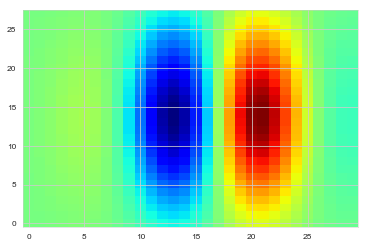

In [3]:
# STRF: keep this very simple for proof of principle
stim_dt = 10.0
nfreq = 28
ntau  = 30
ntbas = 8
kscale = 5
# raised-cosine basis functions
kcosbas = strf.cosbasis(ntau, ntbas)

from scipy.signal import resample
filts = np.load('../../filters.npz')
print(filts.keys())
k1 = resample(filts['bbs'] * kscale, nfreq, axis=0)[:,ntau-1::-1]
k1c = strf.to_basis(k1, kcosbas)

plt.imshow(k1, cmap='jet', aspect='auto')

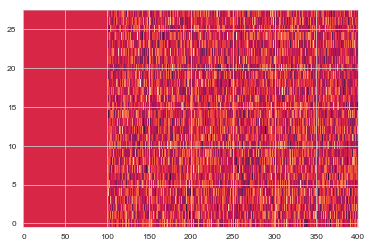

In [4]:
# generate some random data to fit
np.random.seed(1)
stim_dt = 10.0
upsample = int(stim_dt / model_dt)
stim = np.random.randn(nfreq, int(n_samples / (stim_dt / model_dt)))
stim[:,:100] = 0
plt.imshow(stim[:,:400], aspect='auto')

In [5]:
mat.random_seed(1)

def predict_spikes(V, params, dt, upsample):
    omega, a1, a2, t1, t2, tref = params
    return mat.predict_poisson(V - omega, (a1, a2), (t1, t2), tref, 
                               dt, upsample)

data = []
V = strf.convolve(stim, k1)
for i in range(n_assim + n_test):
    spikes = predict_spikes(V, matparams, model_dt, upsample)
    H = mat.adaptation(spikes, matparams[3:5], model_dt)
    z = np.nonzero(spikes)[0]
    d = {"H": H,
         "duration": duration,
         "spike_t": z, 
         "spike_v": spikes,
        }
    data.append(d)

# split into assimilation and test sets
assim_data = data[:n_assim]
test_data = data[n_assim:]

1520

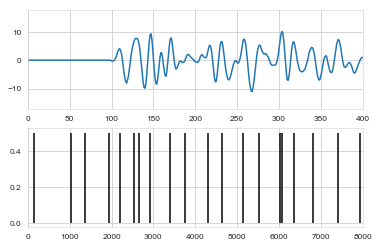

In [6]:
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.plot(V)
for i, d in enumerate(data):
    ax2.vlines(d["spike_t"], i, i + 0.5)
ax1.set_xlim(0, 8000 // upsample)
ax2.set_xlim(0, 8000)
len(data[0]["spike_t"])

## Estimate parameters

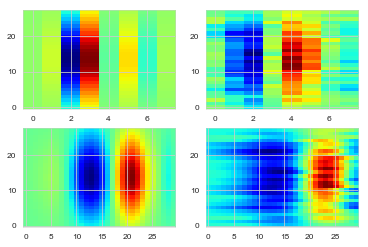

In [7]:
from theano import config
import scipy.optimize as op
ftype = config.floatX

# combine the trials
spikes = np.stack([d["spike_v"] for d in data], axis=1).astype(ftype)
# spikes in the exponential basis set
X_spikes = np.stack([d["H"] for d in data], axis=2).astype(ftype)
# generate design matrix for stimulus
X_stim = strf.lagged_matrix(stim, kcosbas).astype(ftype)

# initial guess of strf
sta = strf.correlate(X_stim, spikes)
rf_sta = strf.as_matrix(sta, ntbas)
plt.subplot(221).imshow(k1c, cmap='jet', aspect='auto')
plt.subplot(222).imshow(rf_sta, cmap='jet', aspect='auto')
plt.subplot(223).imshow(strf.from_basis(k1c, kcosbas), cmap='jet', aspect='auto')
plt.subplot(224).imshow(strf.from_basis(rf_sta, kcosbas), cmap='jet', aspect='auto')

In [ ]:
from theano import function, config, shared, sparse, gradient
import theano.tensor as T
import scipy.sparse as sps

if X_spikes.ndim == 2:
    spike_design = np.expand_dims(X_spikes, 2)
if spikes.ndim == 1:
    spikes = np.expand_dims(spikes, 1)

nframes, nk = X_stim.shape
nbins, nalpha, ntrials = X_spikes.shape
upsample = int(stim_dt / model_dt)
# make an interpolation matrix
interp = sps.kron(sps.eye(nframes),
                  np.ones((upsample, 1), dtype=config.floatX),
                  format='csc')

# load the data into theano.shared structures
M = shared(interp)
dt = shared(model_dt)
Xstim = shared(X_stim)
Xspke = shared(np.rollaxis(X_spikes, 2))
spkx, spky = map(shared, spikes.nonzero())

# split out the parameter vector
w = T.vector('w')
dc = w[0]
h = w[1:(nalpha+1)]
k = w[(nalpha+1):]
Vx = T.dot(Xstim, k)
# Vx has to be promoted to a matrix for structured_dot to work
Vi = sparse.structured_dot(M, T.shape_padright(Vx))
H = T.dot(Xspke, h).T
mu = Vi - H - dc
ll = T.exp(mu).sum() * dt - mu[spkx, spky].sum()
dL = T.grad(ll, w)
# arbitrary vector for hessian-vector product
v = T.vector('v')
ddLv = T.grad(T.sum(dL * v), w)

fV = function([w], Vx)
fH = function([w], H)
fL = function([w], ll)
fgrad = function([w], dL)
fhess = function([w, v], ddLv)

In [10]:
# initial likelihood
w0 = np.r_[0, 0, 0, sta]
fL(w0)

array(3050344.2074347087)

In [11]:
%%time
w0 = np.r_[0, 0, 0, sta]
w1 =  op.fmin_ncg(fL, w0, fgrad, fhess_p=fhess, maxiter=100)

Optimization terminated successfully.
         Current function value: 6349.618684
         Iterations: 42
         Function evaluations: 61
         Gradient evaluations: 102
         Hessian evaluations: 952
CPU times: user 1min 2s, sys: 7.41 s, total: 1min 9s
Wall time: 58 s


[   6.91426427  100.16421125    2.22734958]


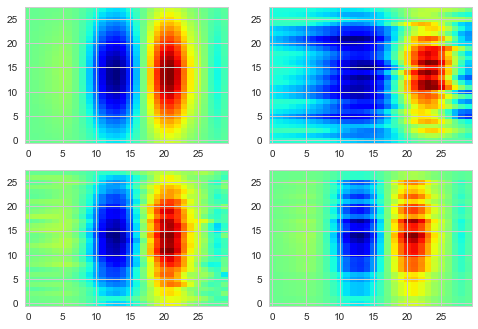

In [55]:
print(w1[:3])
rf_mle = strf.as_matrix(w1[3:], ntbas)
krank = 1
k0f, k0t = strf.factorize(rf_mle, krank)
plt.subplot(221).imshow(strf.from_basis(k1c, kcosbas), cmap='jet', aspect='auto')
plt.subplot(222).imshow(strf.from_basis(rf_sta, kcosbas), cmap='jet', aspect='auto')
plt.subplot(223).imshow(strf.from_basis(rf_mle, kcosbas), cmap='jet', aspect='auto')
plt.subplot(224).imshow(strf.from_basis(np.dot(k0f, k0t), kcosbas), cmap='jet', aspect='auto')

In [58]:
from theano.tensor import slinalg
# split out the parameter vector

nkf = nfreq * krank
nkt = ntbas * krank
w = T.vector('w')
dc = w[0]
h = w[1:(nalpha+1)]
kf = w[(nalpha+1):(nalpha+nkf+1)]
kt = w[(nalpha+nkf+1):(nalpha+nkf+nkt+1)]
k = T.dot(kf.reshape((nfreq, krank)), kt.reshape((krank, ntbas))).ravel()

# convolution: first with block-diagonal matrix containing temporal vectors then with freq vectors
# it might be nice for these to be sparse
# Mkt = T.slinalg.kron(T.eye(nkf), kt.reshape((nkt, krank)))
# Vxt = T.dot(Xstim, Mkt)
# Vx = T.dot(Vxt, kf)
Vx = T.dot(Xstim, k)
# Vx has to be promoted to a matrix for structured_dot to work
Vi = sparse.structured_dot(M, T.shape_padright(Vx))
H = T.dot(Xspke, h).T
mu = Vi - H - dc
ll = T.exp(mu).sum() * dt - mu[spkx, spky].sum()
dL = T.grad(ll, w)
# arbitrary vector for hessian-vector product
v = T.vector('v')
ddLv = T.grad(T.sum(dL * v), w)

fVb = function([w], Vx)
fHb = function([w], H)
fLb = function([w], ll)
fgradb = function([w], dL)
fhessb = function([w, v], ddLv)

In [59]:
from numpy import random
random.seed(10)
w2 = np.r_[0, 0, 0, k0f.flatten(), k0t.flatten()]
%time w3 =  op.fmin_ncg(fLb, w2, fgradb, fhess_p=fhessb, maxiter=100)

Optimization terminated successfully.
         Current function value: 6455.015278
         Iterations: 59
         Function evaluations: 117
         Gradient evaluations: 175
         Hessian evaluations: 776
CPU times: user 1min 8s, sys: 8.6 s, total: 1min 17s
Wall time: 1min 6s


[  6.79824311  93.26586247   2.1432827 ]


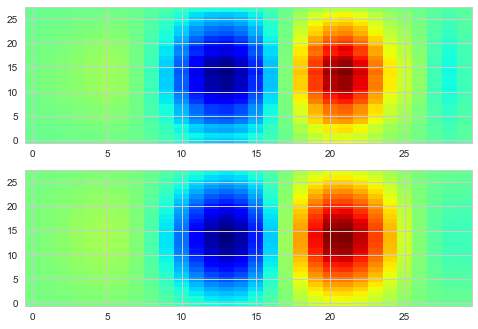

In [60]:
print(w3[:3])
rf_bl = strf.defactorize(w3[3:], nfreq, krank)
plt.subplot(211).imshow(strf.from_basis(rf_bl, kcosbas), cmap='jet', aspect='auto')
plt.subplot(212).imshow(k1, cmap='jet', aspect='auto')